# Image classification using CNN
### Coded by: Abhinav Gupta, 20171059

We train a convolutional neural network with 3 layers depth for classifying images from the VOC dataset. We train the CNN with different loss functions and compare the results. We also experiment with different combinations of convolution, batch norm, pooling and activation layers. We try varying the learning rates and the weight decay hyperparameters as well. 

'Nuff talking, let's begin! Let's first import the libraries we need. We are going to use PyTorch, because it's the best ML library and a gazillion times better than tensorflow. 

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- Let's train a CNN to classify images from the **CIFAR-100 dataset**. The images in this dataset belong to 100 classes. 
- First, we load the data. CIFAR-100 is already present in torchvision woohoo! 

In [44]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

- num_workers denotes the number of subprocesses to use for data loading.
- batch_size denotes the number of samples per batch to load.
- We are going to splot the dataset into train and validation sets. valid_size denotes the percentage of training set to be used as validation. 

In [45]:
num_workers = 0
batch_size = 20
valid_size = 0.2

- We convert data to a normalized torch.FloatTensor

In [46]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
                               ])

In [47]:
# choose the training and test datasets
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


- Now, we need to obtain the training indices that will be used for validation. 
- We then compute the split point between the training and validation set. 
- `train_idx` contains the training image indices, `valid idx` contains the validation set image indices.

In [48]:
num_train = len(train_data) # number of training images
indices = list(range(num_train)) # array of image indices
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
print("number of images in validation set: ", split)
train_idx, valid_idx = indices[split:], indices[:split]

number of images in validation set:  10000


- Now we load the data. We prepare data loaders by combining dataset and samplers. (Taken from the PyTorch documentation) 
- We also specify all the image classes for CIFAR-100. I got that from [here](https://github.com/keras-team/keras/issues/2653)

In [49]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

In [50]:
classes = [ 
'apple', 
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

In [51]:
print(classes[19])

cattle


In [52]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

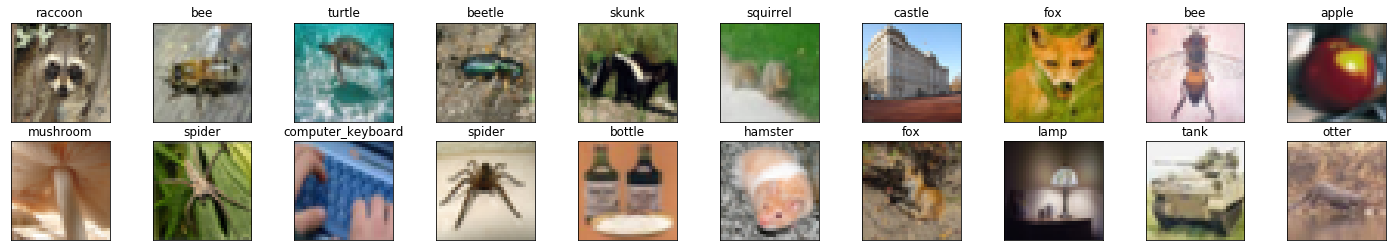

In [53]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Defining the CNN Architecture
Let's first quickly understand what a convolutional neural network is. I got all this from this amazing [medium article](https://medium.com/dataseries/basic-overview-of-convolutional-neural-network-cnn-4fcc7dbb4f17)

We know that computers read images as pixels and it is expressed as a matrix (NxNx3) — (height by width by depth). Depth = 3 implies that images make use of three channels (RGB). 

Let's think of our CNN like this: \
Conv | Activation | Pool \
Conv | Activation | Pool \
Conv | Activation | Pool \
Dropout | FC | Activation \
Dropout | FC | Activation 


#### Convolutional Layer
- The Convolutional Layer makes use of a set of learnable filters. A filter is used to detect the presence of specific features or patterns present in the original image (input). It is usually expressed as a small **patch**matrix (MxMx3), but the same depth as the input file (RGB).
- This filter is convolved/slided across the width and height of the input file, and a dot product is computed to give an activation map. (Similar to what we did in the DSAA course in Spring 2019)
- Different filters which detect different features are convolved on the input file and a set of activation maps is outputted which is passed to the next layer in the CNN.
- We stack up all these activation maps to get a 'new image'! 

Let's say, the original image was 32x32x3. The sliding window was of size 5x5x3. So we slide along the length of the input image, we get (32-5+1) = 28 values. So the activation map becomes (28x28x1). If we do this 6 times with 6 different filters, we get many activation maps. We stack them up and form a new image - 28x28x6. 

- To determine the dimension of the activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file \
P = Padding, F = Dimension of filter and S = Stride

#### Activation Function
- SMAI feels. The activation function is a node that is put at the end of or in between Neural Networks. They help to decide if the neuron would fire or not. As Prof. Jawahar always said, it is used to add non-linearity to the network. Some of the activation functions we used were: Sigmoid, ReLU, Leaky ReLU, tanh etc. 

#### Pooling Layer
- The Pooling layer can be seen **between Convolution layers** in a CNN architecture. This layer basically reduces the number of parameters and computation in the network, controlling overfitting by progressively reducing the spatial size of the network. 
- Max-pooling, like the name states; will take out only the maximum from a pool. This is actually done with the use of filters sliding through the input; and at every stride, the maximum parameter is taken out and the rest is dropped. This actually down-samples the network. 
- Unlike the convolution layer, the pooling layer does not alter the depth of the network, the depth dimension remains unchanged.

#### Fully Connected Layer
- This is the last phase for a CNN network. The Convolutional Neural Network is actually made up of hidden layers and fully-connected layer(s).
- In this layer, the neurons have a complete connection to all the activations from the previous layers. Their activations can hence be computed with a matrix multiplication followed by a bias offset.


In [54]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # convolutional layer (sees 8x8x32 tensor)
        
        self.pool = nn.MaxPool2d(2, 2) # max pooling layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear layer (64 * 4 * 4 -> 500)
        self.fc2 = nn.Linear(500, 100) # linear layer (500 -> 100)
        self.dropout = nn.Dropout(0.25) # dropout layer (p=0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4) # flatten image input
        
        x = self.dropout(x) # add dropout layer
        x = F.relu(self.fc1(x)) # add 1st hidden layer, with relu activation function
        x = self.dropout(x) # add dropout layer
        x = self.fc2(x) # add 2nd hidden layer, with relu activation function
        return x

In [55]:
def train_network(model, optimizer, criterion, model_name):
    # number of epochs to train the model
    n_epochs = 30
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model 
        model.train()
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        # validate the model 
        model.eval()
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_name+'.pt')
            valid_loss_min = valid_loss

### Network-1 - Cross Entropy Loss
Relu network with 3 convolutional layers and 2 fully connected layers.

In [56]:
# create a complete CNN
model1 = Net()
print(model1)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


- We also vary the learning rate, we try 0.01 and 0.1. 
- The model trained with lr = 0.01 is stored in `model_cifar.pt`. 
- The model trained with lr = 0.1 is stored in `cross_entropy_0.1`. My bad, I didn't have time to make different functions. 

In [58]:
# specify optimizer
optimizer1 = optim.SGD(model1.parameters(), lr=0.1)

In [60]:
# specify loss function (categorical cross-entropy)
criterion1 = nn.CrossEntropyLoss()

In [61]:
train_network(model1, optimizer1, criterion1, 'cross_entropy_0.1')

Epoch: 1 	Training Loss: 4.076970 	Validation Loss: 3.615440
Validation loss decreased (inf --> 3.615440).  Saving model ...
Epoch: 2 	Training Loss: 3.353297 	Validation Loss: 3.090023
Validation loss decreased (3.615440 --> 3.090023).  Saving model ...
Epoch: 3 	Training Loss: 3.022999 	Validation Loss: 2.883204
Validation loss decreased (3.090023 --> 2.883204).  Saving model ...
Epoch: 4 	Training Loss: 2.827993 	Validation Loss: 2.722740
Validation loss decreased (2.883204 --> 2.722740).  Saving model ...
Epoch: 5 	Training Loss: 2.715076 	Validation Loss: 2.670904
Validation loss decreased (2.722740 --> 2.670904).  Saving model ...
Epoch: 6 	Training Loss: 2.627167 	Validation Loss: 2.788668
Epoch: 7 	Training Loss: 2.557202 	Validation Loss: 2.698828
Epoch: 8 	Training Loss: 2.495526 	Validation Loss: 2.758745
Epoch: 9 	Training Loss: 2.463791 	Validation Loss: 2.771114
Epoch: 10 	Training Loss: 2.456727 	Validation Loss: 2.698250
Epoch: 11 	Training Loss: 2.432744 	Validation Lo

KeyboardInterrupt: 

- Sorry for the apparent error, as we can see, the model converged after epoch number 6. 
- But I didn't add a condition to stop the training, so it would keep going till Epoch 30. 
- So I just did CTRL-C :P

### Computing the Accuracy
This function takes the model and computes the average test accuracy. 

In [14]:
def compute_accuracy(model, optimizer, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(100))
    class_total = list(0. for i in range(100))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) 
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(100):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

- Accuracy of the network with cross entropy loss function and learning rate = 0.01

In [18]:
model1.load_state_dict(torch.load('model_cifar.pt'))
compute_accuracy(model1, optimizer1, criterion1)

Test Loss: 2.385913

Test Accuracy of apple: 70% (70/100)
Test Accuracy of aquarium_fish: 54% (54/100)
Test Accuracy of  baby: 34% (34/100)
Test Accuracy of  bear: 16% (16/100)
Test Accuracy of beaver: 25% (25/100)
Test Accuracy of   bed: 35% (35/100)
Test Accuracy of   bee: 40% (40/100)
Test Accuracy of beetle: 39% (39/100)
Test Accuracy of bicycle: 36% (36/100)
Test Accuracy of bottle: 48% (48/100)
Test Accuracy of  bowl: 26% (26/100)
Test Accuracy of   boy: 27% (27/100)
Test Accuracy of bridge: 37% (37/100)
Test Accuracy of   bus: 37% (37/100)
Test Accuracy of butterfly: 16% (16/100)
Test Accuracy of camel: 34% (34/100)
Test Accuracy of   can: 40% (40/100)
Test Accuracy of castle: 70% (70/100)
Test Accuracy of caterpillar: 29% (29/100)
Test Accuracy of cattle: 34% (34/100)
Test Accuracy of chair: 65% (65/100)
Test Accuracy of chimpanzee: 66% (66/100)
Test Accuracy of clock: 31% (31/100)
Test Accuracy of cloud: 67% (67/100)
Test Accuracy of cockroach: 64% (64/100)
Test Accuracy of co

#### Image Visualisation

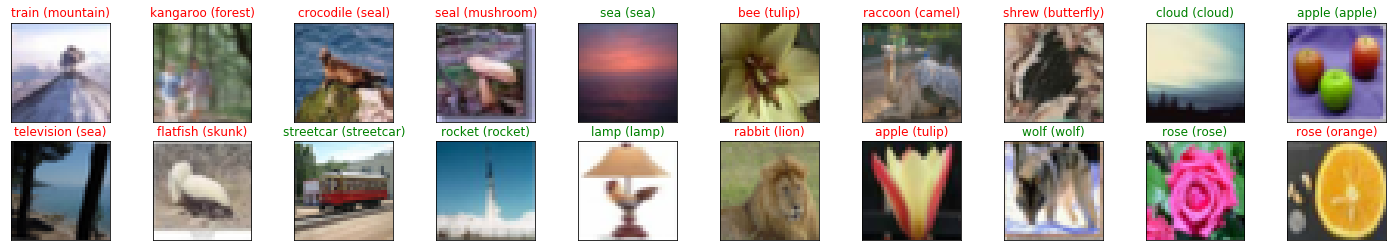

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model1(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Accuracy of the network with cross entropy loss function and learning rate = 0.1

In [62]:
model1.load_state_dict(torch.load('cross_entropy_0.1.pt'))
compute_accuracy(model1, optimizer1, criterion1)

Test Loss: 2.655307

Test Accuracy of apple: 50% (50/100)
Test Accuracy of aquarium_fish: 42% (42/100)
Test Accuracy of  baby: 25% (25/100)
Test Accuracy of  bear:  1% ( 1/100)
Test Accuracy of beaver:  4% ( 4/100)
Test Accuracy of   bed: 35% (35/100)
Test Accuracy of   bee: 35% (35/100)
Test Accuracy of beetle: 26% (26/100)
Test Accuracy of bicycle: 52% (52/100)
Test Accuracy of bottle: 28% (28/100)
Test Accuracy of  bowl: 17% (17/100)
Test Accuracy of   boy:  3% ( 3/100)
Test Accuracy of bridge: 47% (47/100)
Test Accuracy of   bus: 16% (16/100)
Test Accuracy of butterfly: 26% (26/100)
Test Accuracy of camel: 26% (26/100)
Test Accuracy of   can: 26% (26/100)
Test Accuracy of castle: 39% (39/100)
Test Accuracy of caterpillar: 25% (25/100)
Test Accuracy of cattle: 18% (18/100)
Test Accuracy of chair: 61% (61/100)
Test Accuracy of chimpanzee: 68% (68/100)
Test Accuracy of clock: 32% (32/100)
Test Accuracy of cloud: 75% (75/100)
Test Accuracy of cockroach: 58% (58/100)
Test Accuracy of co

- So as we INCREASE the learning parameter, the accuracy falls. 
- This is because very high learning rate is giving more divergence rate, so it's better to keep it lower. 

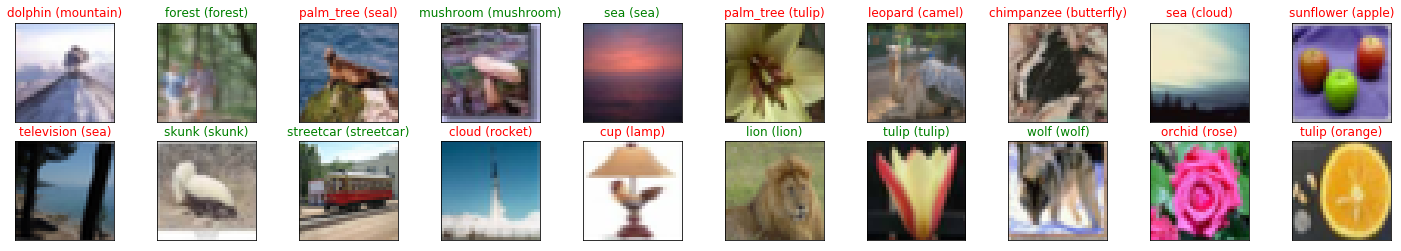

In [63]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model1(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Trying it with different Loss Functions:

- So far, we've been using the cross entropy loss function. 
- Let us now try to use the negative log likelihood loss function. 

In [20]:
# create a complete CNN
model2 = Net()
print(model2)
# specify optimizer
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
# specify loss function
criterion2 = nn.NLLLoss()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
train_network(model2, optimizer2, criterion2, 'NLL_Loss')

Epoch: 1 	Training Loss: nan 	Validation Loss: nan
Epoch: 2 	Training Loss: nan 	Validation Loss: nan


### We notice that it is unable to train, because of we are using Relu activation layer in the model ^
Let's maybe try to decrease the learning rate even further and see if there's any luck.

In [25]:
# create a complete CNN
model3 = Net()
print(model3)
# specify optimizer
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)
# specify loss function
criterion3 = nn.NLLLoss()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
train_network(model3, optimizer3, criterion3, 'NLL-lr')

Epoch: 1 	Training Loss: -0.030377 	Validation Loss: -0.081761
Validation loss decreased (inf --> -0.081761).  Saving model ...
Epoch: 2 	Training Loss: nan 	Validation Loss: nan
Epoch: 3 	Training Loss: nan 	Validation Loss: nan


- We can see that in the first epoch we obtain a **negative** training loss. 
- I googled this and the PyTorch forums advised me to use the softmax activation layer instead of Relu.

#### So let's change the architecture of the network, shall we?

In [17]:
# define the CNN architecture
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # convolutional layer (sees 8x8x32 tensor)
        
        self.pool = nn.MaxPool2d(2, 2) # max pooling layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear layer (64 * 4 * 4 -> 500)
        self.fc2 = nn.Linear(500, 100) # linear layer (500 -> 100)
        self.dropout = nn.Dropout(0.25) # dropout layer (p=0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.softmax(self.conv1(x)))
        x = self.pool(F.softmax(self.conv2(x)))
        x = self.pool(F.softmax(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4) # flatten image input
        
        x = self.dropout(x) # add dropout layer
        x = F.softmax(self.fc1(x)) # add 1st hidden layer, with Log Softmax activation function
        x = self.dropout(x) # add dropout layer
        x = self.fc2(x) # add 2nd hidden layer, with relu activation function
        return x

In [18]:
# create a complete CNN
model4 = Net2()
print(model4)
# specify optimizer
optimizer4 = optim.SGD(model4.parameters(), lr=0.001)
# specify loss function
criterion4 = nn.NLLLoss()

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
train_network(model4, optimizer4, criterion4, 'NLL-softmax')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: -0.009462 	Validation Loss: -0.019341
Validation loss decreased (inf --> -0.019341).  Saving model ...
Epoch: 2 	Training Loss: -0.029518 	Validation Loss: -0.039339
Validation loss decreased (-0.019341 --> -0.039339).  Saving model ...


#### Again this doesn't work :( 
This is because we are using softmax. We need to use **log_softmax**.

In [38]:
# define the CNN architecture
class Net3(nn.Module):
    
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # convolutional layer (sees 8x8x32 tensor)
        
        self.pool = nn.MaxPool2d(2, 2) # max pooling layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear layer (64 * 4 * 4 -> 500)
        self.fc2 = nn.Linear(500, 100) # linear layer (500 -> 100)
        self.dropout = nn.Dropout(0.25) # dropout layer (p=0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.log_softmax(self.conv1(x)))
        x = self.pool(F.log_softmax(self.conv2(x)))
        x = self.pool(F.log_softmax(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4) # flatten image input
        
        x = self.dropout(x) # add dropout layer
        x = F.log_softmax(self.fc1(x)) # add 1st hidden layer, with Log Softmax activation function
        x = self.dropout(x) # add dropout layer
        x = F.log_softmax(self.fc2(x)) # add 2nd hidden layer, with relu activation function
        return x

In [39]:
# create a complete CNN
model5 = Net3()
print(model5)
# specify optimizer
optimizer5 = optim.SGD(model5.parameters(), lr=0.001)
# specify loss function
criterion5 = nn.NLLLoss()

Net3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [40]:
train_network(model5, optimizer5, criterion5, 'NLL-log_softmax')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 7.385885 	Validation Loss: 5.028612
Validation loss decreased (inf --> 5.028612).  Saving model ...
Epoch: 2 	Training Loss: 6.297138 	Validation Loss: 5.072057
Epoch: 3 	Training Loss: 5.690130 	Validation Loss: 4.941643
Validation loss decreased (5.028612 --> 4.941643).  Saving model ...
Epoch: 4 	Training Loss: 5.385903 	Validation Loss: 4.890108
Validation loss decreased (4.941643 --> 4.890108).  Saving model ...
Epoch: 5 	Training Loss: 5.184633 	Validation Loss: 4.769966
Validation loss decreased (4.890108 --> 4.769966).  Saving model ...
Epoch: 6 	Training Loss: 5.045246 	Validation Loss: 4.624692
Validation loss decreased (4.769966 --> 4.624692).  Saving model ...
Epoch: 7 	Training Loss: 4.976586 	Validation Loss: 4.653441
Epoch: 8 	Training Loss: 4.899640 	Validation Loss: 4.530113
Validation loss decreased (4.624692 --> 4.530113).  Saving model ...
Epoch: 9 	Training Loss: 4.859482 	Validation Loss: 4.470174
Validation loss decreased (4.530113 --> 4.

#### WOOOHOO This worked ^_^

In [41]:
model5.load_state_dict(torch.load('NLL-log_softmax.pt'))
compute_accuracy(model5, optimizer5, criterion5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 4.032405

Test Accuracy of apple: 44% (44/100)
Test Accuracy of aquarium_fish:  0% ( 0/100)
Test Accuracy of  baby:  0% ( 0/100)
Test Accuracy of  bear:  0% ( 0/100)
Test Accuracy of beaver:  0% ( 0/100)
Test Accuracy of   bed:  0% ( 0/100)
Test Accuracy of   bee:  3% ( 3/100)
Test Accuracy of beetle:  0% ( 0/100)
Test Accuracy of bicycle:  6% ( 6/100)
Test Accuracy of bottle:  9% ( 9/100)
Test Accuracy of  bowl:  0% ( 0/100)
Test Accuracy of   boy:  0% ( 0/100)
Test Accuracy of bridge:  0% ( 0/100)
Test Accuracy of   bus:  9% ( 9/100)
Test Accuracy of butterfly:  6% ( 6/100)
Test Accuracy of camel:  0% ( 0/100)
Test Accuracy of   can:  5% ( 5/100)
Test Accuracy of castle:  0% ( 0/100)
Test Accuracy of caterpillar:  0% ( 0/100)
Test Accuracy of cattle:  0% ( 0/100)
Test Accuracy of chair: 67% (67/100)
Test Accuracy of chimpanzee:  0% ( 0/100)
Test Accuracy of clock:  0% ( 0/100)
Test Accuracy of cloud: 32% (32/100)
Test Accuracy of cockroach: 65% (65/100)
Test Accuracy of co

#### But the accuracy is super low :( Using Cross Entropy Loss with Relu activation layer was much better. 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


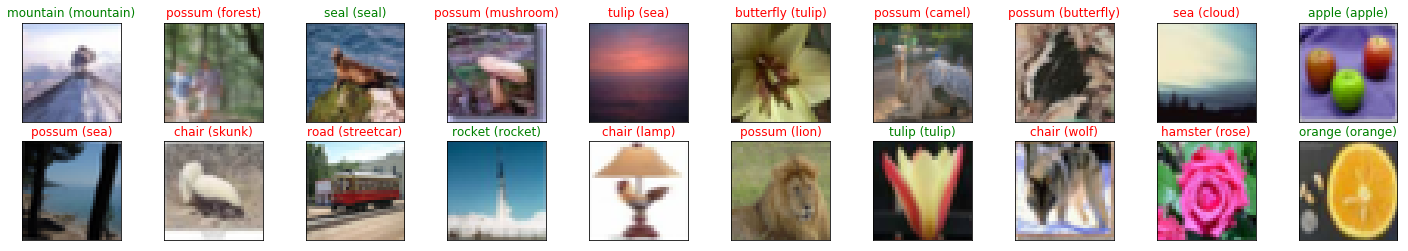

In [42]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model5(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Some more observations

- It honestly doesn't help to incude too many pooling layers because increasing the number of pooling layers is equivalent to decreasing the image resolution. One max pooling layer is sufficient! 
- For Activation functions, it doesn't make much of a difference to use Leaky ReLU because networks aren't very deep. So we don't get much difference! 